# Daymet - NASA Earthdata Cloud-Based OPeNDAP Access and Subsetting

*Author:  ORNL DAAC*
<br>
*Date: August 31, 2021*
<br>
*Contact for [ORNL DAAC](https://daac.ornl.gov/):  uso@daac.ornl.gov*

##### Keywords:  ORNL DAAC, Daymet, THREDDS, OPeNDAP, Earthdata, , `CMR API`, `pydap`, `xarray`

## Tutorial Overview

In this tutorial, we're interested in obtaining a **spatial** and **temporal subset** of gridded multidimentional (ie. netCDF) data from NASA's Earthdata Cloud.  We'll use the North American Daymet V4 daily data as an example.  This tutorial will demonstrate how to programatically discover, access, and subset using bounding box coordinates (e.g. the bounding box of a projected polygon file) Daymet data from NASA's Earthdata Cloud. 

We'll first demonstrate how to search NASA's Dataset Collections and Granules using NASA's CMR API to discover Daymet files that match a set of search parameters. 

Then we'll demonstrate subsetting from the North American Daymet dataset netCDF files using `pydap` to inspect data from the NASA Earthdata Cloud Hyrax OPeNDAP server.

### Daymet Overview

The **[Daymet](https://daymet.ornl.gov/)** dataset provides gridded estimates of daily weather data interpolated and extrapoloated from ground-based surface weather observations.  Annual and monthly climatologies are also available.  The spatial resolution of the data is 1km x 1km and the daily data are distributed in a multidimensional, netCDF file format. Daymet data is available for continenal North America (na), with Hawaii (hi), and Puerto Rico (pr) as separate data files.

The Daymet daily North American files [Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4 R1](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2129) are large and often a researcher only needs a spatial or temporal subset of the data based on their region of interest. 


![title](images/Daymet_V4_Annual_Climatology_Fig1.png)

DAYMET Temporal Availability:

| Spatial Area    | Years                          
|:---------       |:---------------------------------------:|
| North America   | 1980 - present
| Hawaii          | 1980 - present
| Puerto Rico     | 1950 - present

DAYMET VARIABLES:

| Variable | Description (units)                           
|:---------|:---------------------------------------:|
| tmax     | Daily maximum 2-meter air temperature (°C)
| tmin     | Daily minimum 2-meter air temperature (°C)
| prcp     | Daily total precipitation (mm/day)
| srad     | Incident shortwave radiation flux density (W/m2)
| vp       | Water vapor pressure (Pa)
| swe      | Snow water equivalent (kg/m2)
| dayl     | Duration of the daylight period (seconds/day)

Daymet V4 Daily Data files (or granules) are distributed in netCDF4 format, and each file has one year's worth of data. Data files are organized by variables (dayl, prcp, tmin, tmax, srad, swe, vp) and regions (each for na, pr, hi).

The standard naming convention for a file is:  

- daymet_v4_daily_`area`_`variable`_`year`.nc

#### Daymet Data: ORNL DAAC 
- The [Daymet Website](https://daymet.ornl.gov) provides comprehensive information about and access methods for the Daymet datasets under the [Get Data](https://daymet.ornl.gov/getdata) tab. 

- Landing Page for [Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4 R1](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2129).  
- Daymet V4 Daily Data dataset DOI **https://doi.org/10.3334/ORNLDAAC/2129**
<div class="alert alert-block alert-info">
Thornton, M.M., R. Shrestha, Y. Wei, P.E. Thornton, S-C. Kao, and B.E. Wilson. 2022. Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4 R1. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2129
</div>

#### Daymet Data: NASA Earthdata
 - [NASA Earthdata Daymet Collections](https://search.earthdata.nasa.gov/portal/ornldaac/search?fpj=Daymet!Daymet!Daymet)

# Tutorial

Steps we'll explore are: 
1. Use a polygon to get bounding box parameters to use for subsetting from the North American extent of Daymet Data
1. Use the Daymet dataset **DOI** or the Daymet **shortname** and NASA's **Common Metadata Repository (CMR) API** to search for Daymet data within a spatial and temporal region of interest
1. Build a **Request URL** to create a list of files that match our search criteria
1. From Daymet data on the NASA Earthdata Cloud-based Hyrax OPeNDAP Server we will find, subset, and concatenate data as if it were stored locally
1. Download subsets of data NASA Earthdata Cloud to a local computer
1. Clip the subset to our polygon of interest

## Tutorial Requirements
* Python 3.7 or higher
* geopandas and dependencies
* pydap
* xarray
* rasterio
* shapely

In [1]:
#Running from pyenv, Conda, activate hyrax_daymet
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import pyproj
import datetime as dt 
from rasterio.features import Affine
from pydap.client import open_url
from pydap.cas.urs import setup_session
import xarray as xr
import rioxarray
import shapely
import rasterio
from shapely.geometry import mapping
import json

In [3]:
print("This Notebook was produced with the following versions")
print("geopanda version   : ", gpd.__version__)
print("pyproj version     : ", pyproj.__version__)
print("rioxarray version  : ", rioxarray.__version__)
print("xarray version     : ", xr.__version__)
print("shapely            : ", shapely.__version__)
print("rasterio           : ", rasterio.__version__)

This Notebook was produced with the following versions
geopanda version   :  0.10.2
pyproj version     :  3.3.0
rioxarray version  :  0.10.3
xarray version     :  2022.3.0
shapely            :  1.8.0
rasterio           :  1.2.10


In [4]:
!python --version

Python 3.9.12


***
***

## Step 1.  Setting Search and Subset Parameters: Spatial Area of Interest and Time Range of Interest

### 1.1 Search and Subset Parameters: Spatial
We'll start by using a polygon boundary file of California to get the bounding box coordinates to use for metadata discovery and for spatial subsetting. Any polygon area-of-interest can be used.  

We'll use Python's [GeoPandas](https://geopandas.org/index.html) to explore the polygon file

* **`Geopandas`** is an open-sourced library that enables the use and manipulation of geospatial data in Python. It extends the common datatype used in pandas to allow for many unique geometric operations

We'll use the Geopandas **`GeoDataFrame.to_crs`** to reproject the CA polygon file. 

We'll store bounding box coordinates in 2 reference systems
1. **Geographic** WGS84 - for searching NASA Earthdata metadata
2. **Lambert Conformal Conic** - Daymet's CRS - for subsetting the Daymet files using OPeNDAP protocols

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

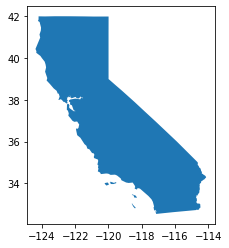

In [5]:
#read and obtain the bounding box of the CA polygon boundary file
ca_poly = gpd.read_file('bnds/California.shp')
ax = ca_poly.plot() # boundary file of California
xy_nad83 = ca_poly.bounds

ca_poly.crs  # Lists the coordinate reference system (crs)

As we see above, the boundary file is in the `EPSG:4269` coordinate system.  This differs from `EPSG:4326` only by the datum. We'll see below that differences will be minor.  

### Geographic Bounding Box - for searching NASA Earthdata CMR Metadata

In [6]:
# Let's determine and store the geographic bounding box of the California for Earthdata Searching
# data can be re-projected using the GeoDataFrame.to_crs() command:
ca_poly_4269 = ca_poly.to_crs(epsg=4326)
xy_wgs84 = ca_poly_4269.bounds # bound of polygon in lat, lon 
xy_wgs84

,minx,miny,maxx,maxy
0,-124.392636,32.535783,-114.125228,42.002192


In [14]:
xy_wgs84 = ca_poly_4269.bounds.values.tolist()[0] # We'll need this as a Python list to serve as a subsetting parameter
print(xy_wgs84)

[-124.39263575019409, 32.53578253612507, -114.1252281747415, 42.002192463378705]


### Lambert Conformal Conic bounding box - Daymet's CRS - for subsetting the file using OPeNDAP protocols
We'll project the polygon geopandas object (`ca_poly`) to LCC using the **`geopandas`** **`to_crs`**.
- Daymet is natively in a `lambert_conformal_conic (LCC)` projection.  
- We'll present two ways to obtain the LCC paramters used to project the California bounding box to LCC.

### LCC Example 1
The Daymet LCC projection parameters are found presented as a `Proj.4 String` in the Daymet [User Guide](https://daac.ornl.gov/DAYMET/guides/Daymet_Daily_V4R1.html).

<div class="alert alert-block alert-info">
PROJ.4: +proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs
</dev>

In [15]:
# Define the Daymet projection using the Proj.4 String
daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"

# Project the California polygon to LCC 
ca_poly_lcc_1 = ca_poly.to_crs(daymet_proj) # to_crs re-projects from 4269 to LCC
ca_poly_lcc_1.crs

<Derived Projected CRS: +proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.31424 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### LCC Example 2
Or, use a Daymet file and `rioxarray` to obtain the LCC projection parameters

In [16]:
# Obtain the Daymet LCC projection parameters from a Daymet file
daymet_x = xr.open_dataset('daymet_v4_tmax_annavg_pr_1950.nc',  decode_coords="all")
daymet_x.rio.crs
daymet_x_proj = daymet_x.rio.crs

# Project the California polygon to LCC
ca_poly_lcc_2 = ca_poly.to_crs(daymet_x_proj) # to_crs re-projects from 4269 to LCC
ca_poly_lcc_2.crs

<Derived Projected CRS: PROJCS["undefined",GEOGCS["undefined",DATUM["undef ...>
Name: undefined
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: undefined
- Ellipsoid: undefined
- Prime Meridian: Greenwich

### Save the CA Bounding Box in LCC Projection

In [17]:
lccbounds = ca_poly_lcc_2.bounds # Bounds in LCC projection
print('Projected bounding box of the California polygon file in LCC projection')
print('----------------------------------------------------------------------------------')
lccbounds.round(2)

Projected bounding box of the California polygon file in LCC projection
----------------------------------------------------------------------------------


,minx,miny,maxx,maxy
0,-1949774.11,-924691.39,-1249285.39,222385.26


### Plot the CA files

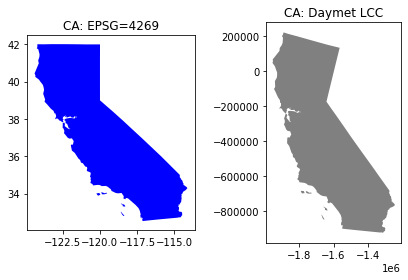

In [18]:
# plot the CA polygon in EPSG:4269 and the Lambert Conformal Conic projection
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))
ca_poly.plot(ax=ax1, facecolor='blue');
ax1.set_title("CA: EPSG=4269");
ca_poly_lcc_2.plot(ax=ax2, facecolor='grey');
ax2.set_title("CA: Daymet LCC");
plt.tight_layout()

### 1.2 Search and Subset Parameters: Temporal
This sets and formats a time range of interest to discover and subset data

In [19]:
import datetime as dt 

start_date = dt.datetime(2010, 1, 1) # specify your own start date
end_date = dt.datetime(2011, 12, 31)  # specify your end start date
print(start_date,end_date,sep='\n')

dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)
print(temporal_str)

2010-01-01 00:00:00
2011-12-31 00:00:00
2010-01-01T00:00:00Z,2011-12-31T00:00:00Z


## Step 2. Leveraging NASA's Common Metadata Repository (CMR) API to search NASA Earthdata for Daymet data within a spatial and temporal region of interest

##### Now that we've defined our spatial and temporal area-of-interest, we'll see how we can programatically use those as a search parameters to discover the Daymet Daily data within NASA Earthdata holdings that match those parameters .  

##### At the end of this step, we will have a list of Daymet files that are within our search criteria (bounding box and time period).

### A little background ...

For the most recent Daymet data, visit the [Daymet web site](https://daymet.ornl.gov/), or search Daymet in [NASA's Earchdata Search](https://search.earthdata.nasa.gov/search).  Search `Daymet daily` to refine your search relevant to this tutorial.    

<div class="alert alert-block alert-info">
Thornton, M.M., R. Shrestha, Y. Wei, P.E. Thornton, S-C. Kao, and B.E. Wilson. 2022. Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4 R1. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2129
</div>


#### Daymet in NASA's EarthData Cloud

We'll demonstrate how to use either the Daymet dataset `DOI` or the `shortname` to obtain the NASA EarthData's unique ID (called the `Concept ID`) for the most current **Daymet Daily** data using NASA's [CMR API](https://cmr.earthdata.nasa.gov/search).  With this information, we can search all NASA Earthdata holdings for matching data files (granules) based on our spatial area and time period of interest.

Search NASA Earthdata Holdings based on...
* DOI
* ConceptID
* Area of Interest
* Time Range of Interest

#### Obtaining the Daymet V4 Daily data *Concept ID*
Using Python's **`requests`** library, we will build and provide the URL `doisearch` to search **NASA's Metadata Repository** to acquire the **concept_id** unique to the Daymet V4 Daily data in NASA's Cloud holdings.  We'll use the **concept_id** in a next step when we search NASA Cloud Holdings for our spatial and temporal area of interest.

* **`requests`** is a simple HTTP libray for Python.  It allows you to easily send HTTP requests. 


In [20]:
import requests
daymet_doi = '10.3334/ORNLDAAC/2129' # define the DOI as the variable `daymet_doi`
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doisearch = cmrurl + 'collections.json?doi=' + daymet_doi # 
print('Earthdata Metadata for DaymetV4R1 Daily --> ' , doisearch)

Earthdata Metadata for DaymetV4R1 Daily -->  https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/2129


In [21]:
response = requests.get(doisearch)
collection = response.json()['feed']['entry'][0]
#print(collection)
concept_id = collection['id']
print('NASA Earthdata Cloud-based Concept_ID --> ' , concept_id)

NASA Earthdata Cloud-based Concept_ID -->  C2532426483-ORNL_CLOUD


In [22]:
import requests

doi = '10.3334/ORNLDAAC/2129'# Daymet V4R1 DOI 

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']
print(concept_id)

C2532426483-ORNL_CLOUD


`C2532426483-ORNL_CLOUD` is the unique NASA-given concept ID for the Daymet dataset. We can use this to search relevant granules and their names. 

In [23]:
params = {
    'short_name': 'Daymet_Daily_V4R1_2129',
} # parameter dictionary with known CMR short_name

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
cmr_response = requests.get(cmr_collections_url, params=params)
print(cmr_response)
cmr_results = json.loads(cmr_response.content) # Get json response from CMR collection metadata
#print(cmr_results)
collectionlist = [el['id'] for el in cmr_results['feed']['entry']]
print(collectionlist)
concept_id = collectionlist[0]
print(concept_id)

<Response [200]>
['C2532426483-ORNL_CLOUD']
C2532426483-ORNL_CLOUD


##### Searching for Daymet Files 
Daymet daily data files (or granules) are in netCDF4 format, and each file has one year's worth of data. Data files are organized by variables (each for dayl, prcp, tmin, tmax, srad, swe, vp) and regions (each for US, PR, HI). We will first search for all the granules in the area of interest (i.e., California) and a time period of interest.  Daymet filenames can be used to identify the files from continental North America (`*_na_*.nc`). The files from Puerto Rico and Hawaii are named as (`*_pr_*.nc`) and (`*_hi_*.nc`) respectively. For this tutorial, we will download precipitation data (`tmax`) for the year 2010-2020.

For our search, we'll use the Bounding Box of the State of California that we defined above.

We'll also define a `time range` (2010, 2011) in a format that the API recognizes and the Daymet `variable` (tmax) of interest :

In [24]:
import datetime as dt 

start_date = dt.datetime(2010, 1, 1) # specify your own start date
end_date = dt.datetime(2011, 1, 1)  # specify your end start date
#updated to one day for Hyrax testing on Dec 09, 2021
#start_date = dt.datetime(2010, 2, 1) # specify your own start date
#end_date = dt.datetime(2010, 2, 1)  # specify your end start date

print(start_date,end_date,sep='\n')

dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

print('\n')

#var = 'prcp' # select your own variable
var = 'tmax' # select your own variable

print('Variables we have defined to pass to the CMR API')
print('-----------------------------------------------')
print('time range :     ', temporal_str)
print('Daymet variable :', var)
print('bounding box :   ', xy_wgs84)
print('concept ID :     ', concept_id)
print('cmr url :        ', cmrurl)

2010-01-01 00:00:00
2011-01-01 00:00:00


Variables we have defined to pass to the CMR API
-----------------------------------------------
time range :      2010-01-01T00:00:00Z,2011-01-01T00:00:00Z
Daymet variable : tmax
bounding box :    [-124.39263575019409, 32.53578253612507, -114.1252281747415, 42.002192463378705]
concept ID :      C2532426483-ORNL_CLOUD
cmr url :         https://cmr.earthdata.nasa.gov/search/


In [25]:
granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy_wgs84))
print(granulesearch)                

https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2532426483-ORNL_CLOUD&page_size=1000&temporal=2010-01-01T00:00:00Z,2011-01-01T00:00:00Z&bounding_box[]=-124.39263575019409,32.53578253612507,-114.1252281747415,42.002192463378705


##### Searching NASA's Earthdata holdings
Using Python's **`requests`** library, we can provide the URL `granulesearch` created above to search **NASA's Earthdata Metadata** holdings for Daymet data that fit our spatial, temporal, and variable request.

In [26]:
response = requests.get(granulesearch)
granules = response.json()['feed']['entry']  
granule_names = []
for g in granules:
    granule_name = g['title']
    if var in granule_name:
        granule_names.append(granule_name)
        print(granule_name)

Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2010.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2011.nc


Now the array `granule_names` contains the names of all the granules we need.

**Note:** A typical Daymet V4 daily file has the name **daymet_v4_daily_`area`_`var`_`year`.nc**.  The beginning of the filename (**"Daymet_Daily_V4R1."**) is specific to the cloud-based naming convention and because we are searching CMR, the cloud-based files will be discovered.  

### Step 3. Subsetting data from NASA Earthdata Cloud
Daymet data is available through the NASA EarthData Cloud. Next, we will reduce the North American files to our area of interest using the bounding box from the California polygon.

We'll use Pythons **`pydap`** library and the bounding box of the polygon file.

* **`pydap`** can be used to inspect data from any scientific dataset available on the internet from OPeNDAP servers. This allows inspection and manipulation of scientific data as if it were stored locally.  Data can be downloaded on-the-fly as needed.

* **`OPeNDAP`**, an acronym for "Open-source Project for a Network Data Access Protocol, enables remote data-retrieval as a Web service.

Pydap Xarray open_dataset *Parameters*
* **[xarray.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)** 






In [27]:
# THIS IS ACCESSING DAYMET DAILY DATA in NGAP HYDRAX via OPeNDAP.  
# for loop based on response granules eg.) Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc, Daymet_Daily_V4.daymet_v4_daily_na_tmax_2011.nc 

from pydap.client import open_url
from pydap.cas.urs import setup_session
import xarray as xr
import time

username = "xxxxxx" # Earthdata URS Login (only needed for NGAP Hyrax) Get account here https://urs.earthdata.nasa.gov/
password= "xxxxxxx"

hyrax_url = 'https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/'

session = setup_session(username, password, check_url=hyrax_url)  

before = time.time()
cnt = 0 
for g_name in granule_names:
    print('granule_name ---->', g_name)
    #granule_dap = thredds_url + g_name.replace('Daymet_Daily_V4R1.','') #The name suffix is needed for cloud file name
    granule_dap = hyrax_url + g_name 
    print(granule_dap)
    
    hyrax_ds = open_url(granule_dap, session=session)
    ds = xr.open_dataset(xr.backends.PydapDataStore(hyrax_ds), decode_coords="all")
    print(ds)
    
    dummy=ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
    print('dummy')
    print(dummy)
    #dummy=ds['prcp'].sel(x=slice(1386957,1470587), y=slice(-565105,-612937))
    if cnt==0:
        tmax_h = dummy
        print('tmax_h ====')
        print(tmax_h)
        tmax_h.to_netcdf('test.nc')
    else:
        tmax_h = xr.concat([tmax_h, dummy], dim="time")
    
    cnt += 1

print(tmax_h)    
# save to netcdf
tmax_h.to_netcdf(var + '_cali_hyrax_subset.nc')
print("Processing Time: ", time.time() - before, 'seconds')

granule_name ----> Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2010.nc
https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2010.nc
<xarray.Dataset>
Dimensions:                  (y: 8075, x: 7814, time: 365, nv: 2)
Coordinates:
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
    lon                      (y, x) float32 ...
    lambert_conformal_conic  int16 ...
  * time                     (time) datetime64[ns] 2010-01-01T12:00:00 ... 20...
    lat                      (y, x) float32 ...
    time_bnds                (time, nv) datetime64[ns] ...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
Dimensions without coordinates: nv
Data variables:
    yearday                  (time) int16 ...
    tmax                     (time, y, x) float32 ...
Attributes:
    build_dmrpp_metadata.build_dmrpp:    3.20.10-462
    build_dmrpp_metadata.bes:            3.20.10-462
    build_d

In [28]:
tmax_h

<xarray.DataArray 'tmax' (time: 730, y: 1147, x: 700)>
array([[[  nan,   nan,   nan, ...,  6.15,  6.12,  6.11],
        [  nan,   nan,   nan, ...,  6.12,  6.12,  6.1 ],
        [  nan,   nan,   nan, ...,  6.11,  6.09,  6.09],
        ...,
        [  nan,   nan,   nan, ..., 21.15, 21.17, 21.18],
        [  nan,   nan,   nan, ..., 21.19, 21.21, 21.21],
        [  nan,   nan,   nan, ..., 21.23, 21.24, 21.26]],

       [[  nan,   nan,   nan, ...,  6.17,  6.2 ,  6.2 ],
        [  nan,   nan,   nan, ...,  6.15,  6.18,  6.18],
        [  nan,   nan,   nan, ...,  6.14,  6.17,  6.18],
        ...,
        [  nan,   nan,   nan, ..., 22.65, 22.65, 22.65],
        [  nan,   nan,   nan, ..., 22.67, 22.67, 22.67],
        [  nan,   nan,   nan, ..., 22.69, 22.69, 22.69]],

       [[  nan,   nan,   nan, ...,  4.23,  4.24,  4.27],
        [  nan,   nan,   nan, ...,  4.23,  4.27,  4.29],
        [  nan,   nan,   nan, ...,  4.25,  4.27,  4.31],
        ...,
...
        ...,
        [  nan,   nan,   nan, ..., 22.13, 22.12, 22.11],
        [  nan,   nan,   nan, ..., 22.12, 22.11, 22.11],
        [  nan,   nan,   nan, ..., 22.12, 22.11, 22.1 ]],

       [[  nan,   nan,   nan, ..., 10.87, 10.77, 10.63],
        [  nan,   nan,   nan, ..., 10.83, 10.77, 10.65],
        [  nan,   nan,   nan, ..., 10.84, 10.77, 10.68],
        ...,
        [  nan,   nan,   nan, ..., 23.95, 23.95, 23.95],
        [  nan,   nan,   nan, ..., 23.94, 23.95, 23.95],
        [  nan,   nan,   nan, ..., 23.94, 23.95, 23.95]],

       [[  nan,   nan,   nan, ...,  5.77,  5.76,  5.71],
        [  nan,   nan,   nan, ...,  5.72,  5.75,  5.71],
        [  nan,   nan,   nan, ...,  5.72,  5.74,  5.72],
        ...,
        [  nan,   nan,   nan, ..., 24.57, 24.58, 24.58],
        [  nan,   nan,   nan, ..., 24.57, 24.57, 24.58],
        [  nan,   nan,   nan, ..., 24.56, 24.57, 24.57]]], dtype=float32)
Coordinates:
  * y                        (y) float32 2.22e+05 2.21e+05 ... -9.24e+05
    lon                      (y, x) float32 -125.0 -125.0 ... -113.9 -113.8
    lambert_conformal_conic  int16 -32767
  * time                     (time) datetime64[ns] 2010-01-01T12:00:00 ... 20...
    lat                      (y, x) float32 41.82 41.82 41.83 ... 32.84 32.84
  * x                        (x) float32 -1.949e+06 -1.948e+06 ... -1.25e+06
Attributes:
    long_name:     daily maximum temperature
    units:         degrees C
    cell_methods:  area: mean time: maximum

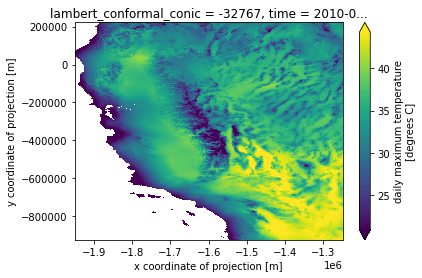

In [29]:
import matplotlib.pyplot as plt
tmax = tmax_h.isel(time=200) # isel = xarray index selection (python index start from 0, so day 7) 
ax = plt.subplot()
tmax.plot(ax=ax, robust=True)
# Note xarray uses dimension and attribute information image - time:2010-01-07, projection is recognized

In [ ]:
# SKIP THIS - TESTING WITH ONE SLICE
# THIS IS ACCESSING DAYMET DAILY DATA in NGAP HYDRAX via OPeNDAP.  
# for loop based on response granules eg.) Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc, Daymet_Daily_V4.daymet_v4_daily_na_tmax_2011.nc 

from pydap.client import open_url
from pydap.cas.urs import setup_session
import xarray as xr
import time

username = "xxxxxx" # Earthdata URS Login (only needed for NGAP Hyrax) Get account here https://urs.earthdata.nasa.gov/
password= "xxxxxxx"

hyrax_url = 'https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/'

session = setup_session(username, password, check_url=hyrax_url)  

before = time.time()
cnt = 0 
for g_name in granule_names:
    print('granule_name ---->', g_name)
    #granule_dap = thredds_url + g_name.replace('Daymet_Daily_V4R1.','') #The name suffix is needed for cloud file name, not here for TDS
    granule_dap = hyrax_url + g_name 
    print(granule_dap)
    
    hyrax_ds = open_url(granule_dap, session=session)
    ds = xr.open_dataset(xr.backends.PydapDataStore(hyrax_ds), decode_coords="all")
    
    subset=ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
    print(subset)
    #dummy=ds['tmax'].sel(x=slice(1386957,1470587), y=slice(-565105,-612937))
    #subset.to_netcdf(g_name.replace('Daymet_Daily_V4R1.','CAsubset_'))
    #subset.to_netcdf(CA_test)
    
    #if cnt==0:
    #    tmax_h = dummy
    #else:
    #    tmax_h = xr.concat([tmax_h, dummy], dim="time")
    
    #cnt += 1

# save to netcdf
#tmax_h.to_netcdf(var + '_cali_hyrax_subset.nc')
#granule_name ----> Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc
#subset.to_netcdf(g_name.replace('Daymet_Daily_V4R1.','CAsubset_'))
print("Processing Time: ", time.time() - before, 'seconds')

##### Let's take a look at the Daymet Temperature Subset for 2011

In [ ]:
#subset

In [ ]:
###SKIP THIS
import matplotlib.pyplot as plt
#tmax_ca = subset.isel(time=6) # isel = xarray index selection (python index start from 0, so day 7) 
tmax_ca = tmax_h.isel(time=6) # isel = xarray index selection (python index start from 0, so day 7) 
ax = plt.subplot()
tmax_ca.plot(ax=ax, robust=True)
# Note xarray uses dimension and attribute information image - time:2010-01-07, projection is recognized

<AxesSubplot:title={'center':'lambert_conformal_conic = -32767, time = 2010-0...'}, xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

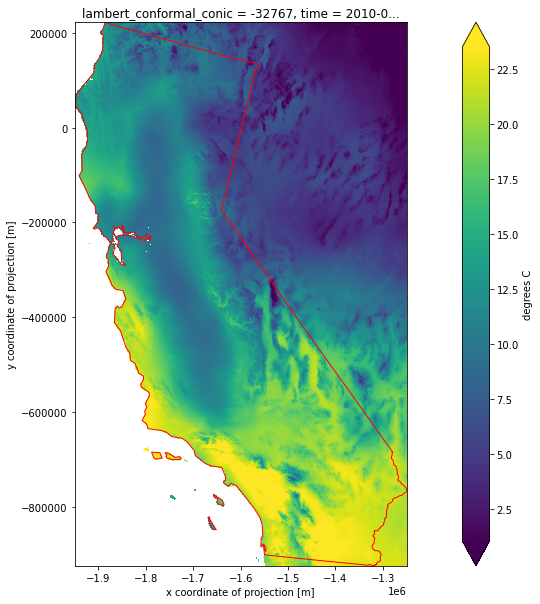

In [30]:
import matplotlib.pyplot as plt
tmax_ca = tmax_h.isel(time=6)
fig, ax = plt.subplots(figsize = (20,10))
tmax_ca.plot(ax=ax, robust=True, cbar_kwargs={'label': 'degrees C'})
ca_poly_lcc_1.plot(ax = ax, color = 'none', edgecolor = 'red')

### Step 4. Clipping the subset area by polygon
In this step, we demonstrate how to clip the subset to our polygon of interest.  We'll use Python's *rasterio* library.

* **`rasterio`** provides many capabilities found in GDAL

First, we'll map the subset precipitation data matrix to real world coordinates using the **'translation'** and **'scale'** methods of **'Affine'**.

In [31]:
from rasterio.features import Affine
res = 1000 # daymet spatial resolution is 1km x 1km
#transform = Affine.translation(min(subset.x).values - res / 2, min(subset.y).values - res / 2) * Affine.scale(res, res)
transform = Affine.translation(min(tmax_h.x).values - res / 2, min(tmax_h.y).values - res / 2) * Affine.scale(res, res)
transform

Affine(1000.0, 0.0, -1949750.0,
       0.0, 1000.0, -924500.0)

In [32]:
from rasterio.features import geometry_mask
#ca_mask = geometry_mask(ca_poly_lcc_1.geometry, out_shape=(len(subset.y), len(subset.x)), transform=transform, invert=True)
ca_mask = geometry_mask(ca_poly_lcc_1.geometry, out_shape=(len(tmax_h.y), len(tmax_h.x)), transform=transform, invert=True)
polymask = xr.DataArray(ca_mask , dims=("y", "x"))
polymask = polymask.sel(y=slice(None, None, -1)) 
tmax_masked = tmax_h.where(polymask == True)
# write out to a netCDF file
tmax_masked.to_netcdf(var + '_subset_poly.nc')

Now let's plot the subset for the day

In [ ]:
##SKIP THIS
import matplotlib.pyplot as plt
tmax_1 = tmax_masked.isel(time=6)
ax = plt.subplot()
tmax_1.plot(ax=ax, cmap="turbo", cbar_kwargs={'label': 'degrees C'})

<AxesSubplot:title={'center':'lambert_conformal_conic = -32767, time = 2010-0...'}, xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

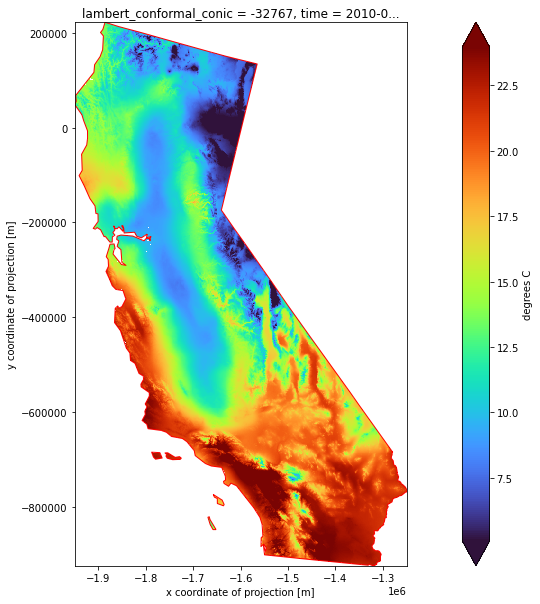

In [33]:
import matplotlib.pyplot as plt
tmax_1 = tmax_masked.isel(time=6)
fig, ax = plt.subplots(figsize = (20,10))
tmax_1.plot(ax=ax, robust=True, cmap="turbo", cbar_kwargs={'label': 'degrees C'})
ca_poly_lcc_1.plot(ax = ax, color = 'none', edgecolor = 'red')

#### Saving to a GeoTIFF
The subset data can also be clipped by a polygon of interest and converted to GeoTiff using the rioxarray and shapely libraries.

* **`rioxarray`** is an extention of xarray.  It can be used to clip, merge, and reproject rasters
* **`shapely`** is a Python package for manipulation and analysis of planar geometery objects

In [36]:
import rioxarray
from shapely.geometry import mapping
print(var)

#prcp_sub = rioxarray.open_rasterio(var + '_subset_poly.nc', decode_coords="all")
#tmax_sub = rioxarray.open_rasterio(var + '_tdssubset.nc', decode_coords="all", decode_times=False)

#tmax_sub = rioxarray.open_rasterio(var + '_subset_poly.nc', decode_coords="all", decode_times=False)
tmax_sub = rioxarray.open_rasterio(var + '_cali_hyrax_subset.nc', masked=True)
tmax_clip = tmax_sub.tmax.rio.clip(ca_poly_lcc_1.geometry.apply(mapping), ca_poly_lcc_1.crs, invert=False, from_disk=True)

# saving one time step to geotiff
tmax_clip_day6 = tmax_clip.isel(time=6)
tmax_clip_day6.rio.to_raster("tmax_clip_day6.tif")

tmax
